In [1]:
import os
import copy
import shutil
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mlp
import seaborn as sns
%matplotlib inline
from transformers import AutoTokenizer, AutoModelWithLMHead
import shap
from shap.utils import GenerateLogits
import scipy as sp
import nlp
import torch
import spacy
from shap.utils import assert_import, record_import_error, safe_isinstance, make_masks, OpChain, MaskedModel
from shap import maskers, links

In [2]:
dataset = nlp.load_dataset('xsum',split='train')

WARNING - Using custom data configuration default


In [3]:
tokenizer = AutoTokenizer.from_pretrained("sshleifer/distilbart-xsum-12-6")
model =  AutoModelWithLMHead.from_pretrained("sshleifer/distilbart-xsum-12-6")

The class `AutoModelWithLMHead` is deprecated and will be removed in a future version. Please use `AutoModelForCausalLM` for causal language models, `AutoModelForMaskedLM` for masked language models and `AutoModelForSeq2SeqLM` for encoder-decoder models.


In [5]:
# Instantiate object of GenerateLogits with model and tokenizer
logit_generator_model = GenerateLogits(model=model,tokenizer=tokenizer,device='cpu')

In [17]:
def f_predict(x):
    model.eval()
    input_ids = torch.tensor([tokenizer.encode(x)])
    with torch.no_grad():
        out=model.generate(input_ids)
    sentence = [tokenizer.decode(g, skip_special_tokens=True) for g in out][0]
    del input_ids, out
    return sentence

In [18]:
def gen_kwargs(x):
    model.eval()
    input_ids = torch.tensor([tokenizer.encode(x)])
    with torch.no_grad():
        # generate input ids for output translation which we aim to explain
        out=model.generate(input_ids)
    # slice sentence by removing bos and eos token ids
    target_sentence_ids = out[:,1:-1]
    output_names = logit_generator_model.get_output_names(target_sentence_ids)
    del out
    return {'target_sentence_ids':target_sentence_ids,'input_ids':input_ids,'output_names':output_names,'fixed_context':0}

In [19]:
# This function defines the additional arguments passed onto the model function required inorder to get conditional logits corresponding to the original input sentence translation
def f_kwargs(x):
    kwargs = gen_kwargs(x)
    return kwargs

In [20]:
def f(x_batch,**kwargs):
    output_batch=[]
    # Extract target sentence for which we want to generate conditional logits
    target_sentence_ids=kwargs['target_sentence_ids']
    for i,source_sentence in enumerate(x_batch):
        conditional_logits = logit_generator_model.generate_logits(source_sentence,target_sentence_ids)
        output_batch.append(conditional_logits)
    return np.array(output_batch)

In [21]:
explainer = shap.Explainer(f,tokenizer)
explainer.masker.mask_token_id=None
explainer.masker.mask_token=""

In [22]:
row_args=(dataset['document'][0],)
fm = MaskedModel(explainer.model, explainer.masker, explainer.link,*row_args,model_kwargs=f_kwargs)
explainer._clustering = explainer.masker.clustering(*row_args)

In [23]:
feature_names = [explainer.masker.tokenizer.decode([v]) for v in explainer.masker._tokenized_s]

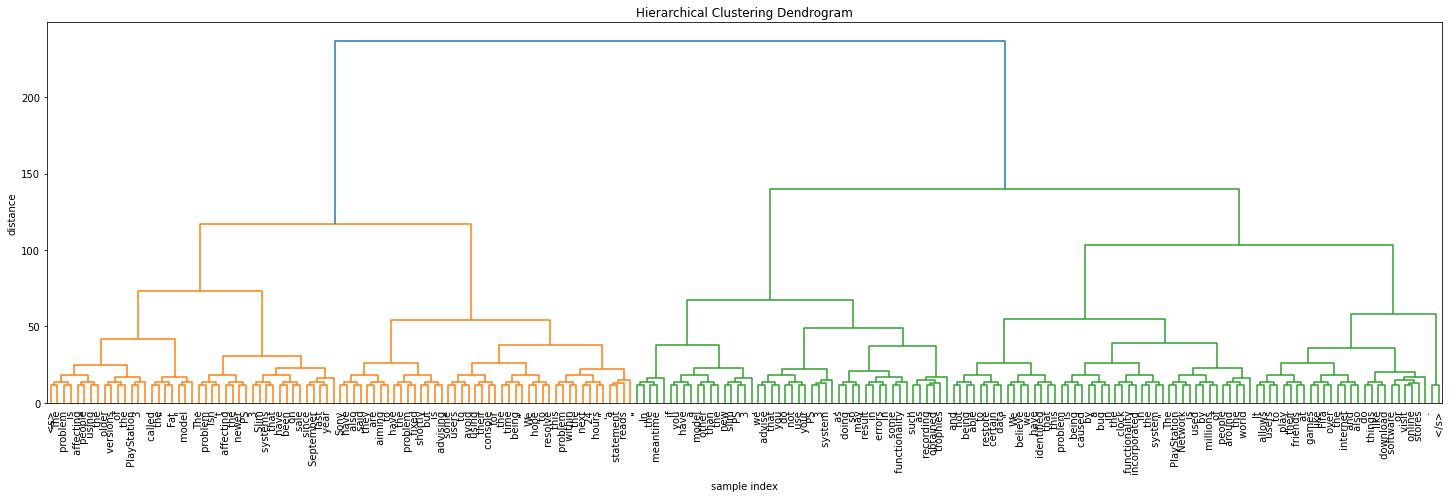

In [26]:

# plot the clustering
mlp.rcParams['figure.figsize']=(25,7)
#plt.figure(figsize=(25, 7))
plt.title('Hierarchical Clustering Dendrogram')
plt.xlabel('sample index')
plt.ylabel('distance')
sp.cluster.hierarchy.dendrogram(
    explainer._clustering,
    leaf_rotation=90.,  # rotates the x axis labels
    leaf_font_size=10.,  # font size for the x axis labels
    labels=feature_names,
)
plt.show()